<a href="https://www.kaggle.com/code/najeebz/bank-churn-gridsearchcv-xgboost-gradient-boost?scriptVersionId=162792405" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# [Binary Classification with a Bank Churn Dataset](https://www.kaggle.com/competitions/playground-series-s4e1/overview)
### Playground Series - Season 4, Episode 1
_______________________________________________________________________ 
# Author Details:
- Name: Najeeb Haider Zaidi
- Email: zaidi.nh@gmail.com
- Profiles: [Github](https://github.com/snajeebz)  [LinkedIn](https://www.linkedin.com/in/najeebz) [Kaggle](https://www.kaggle.com/najeebz)
- Prepared for the submission to the competition.
________________________________________________________________________
# Attributions:


[Walter Reade, Ashley Chow. (2024). Binary Classification with a Bank Churn Dataset . Kaggle.](https://kaggle.com/competitions/playground-series-s4e1)
________________________________________________________________________
​
This Notebook is to be submitted to the competition so aims to start the process from the beginning to the creation of the submission csv file in proper format.
__________________________________________________________________________
# Code Execution and Versioning Repository: 
- [Execute the notebook in Kaggle](https://www.kaggle.com/code/najeebz/bank-churn-gridsearchcv-xgboost-gradient-boost)
- [Github Repository](https://github.com/snajeebz/playground)
​
____________________________________________________________________
# Citation:

Najeeb Zaidi. (2024). Binary Classification with a Bank Churn Dataset. Competition Submission. Kaggle. https://www.kaggle.com/code/najeebz/bank-churn-gridsearchcv-xgboost-gradient-boost

# Initiating the Notebook

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from warnings import filterwarnings;
filterwarnings('ignore');

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


# Reading the Dataset

In [16]:
df=pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

In [17]:
test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [18]:
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Analyzing the data

In [19]:
test.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [20]:
df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [21]:
df.Geography.value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

In [22]:
df.NumOfProducts.value_counts()


NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

In [23]:
df.IsActiveMember.describe()

count    165034.000000
mean          0.497770
std           0.499997
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: IsActiveMember, dtype: float64

In [24]:
df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Visualization

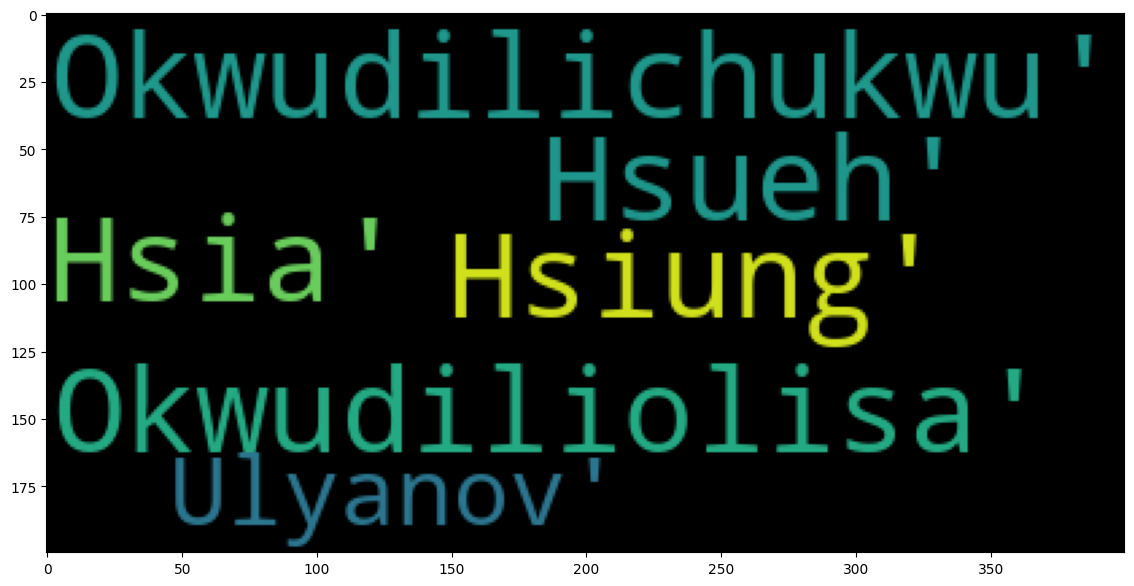

In [25]:
from wordcloud import WordCloud, STOPWORDS

text = df['Surname'].values 
plt.figure(figsize=[15,7])
wc = WordCloud().generate(str(text))
plt.imshow(wc)

In [26]:
train_df=df[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited']]
train_df
test_df=test[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

In [27]:
cat_cols = df[['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited']]
num_cols= train_df[['CreditScore', 'Age','Balance','EstimatedSalary']]

## Categorical Count Plots:

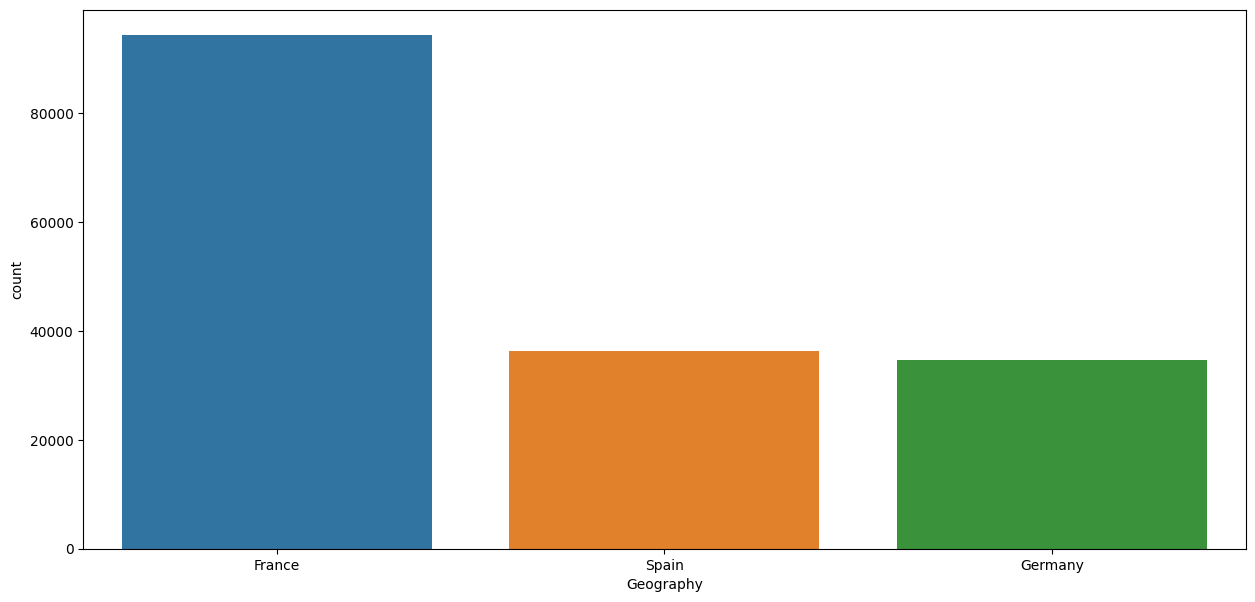

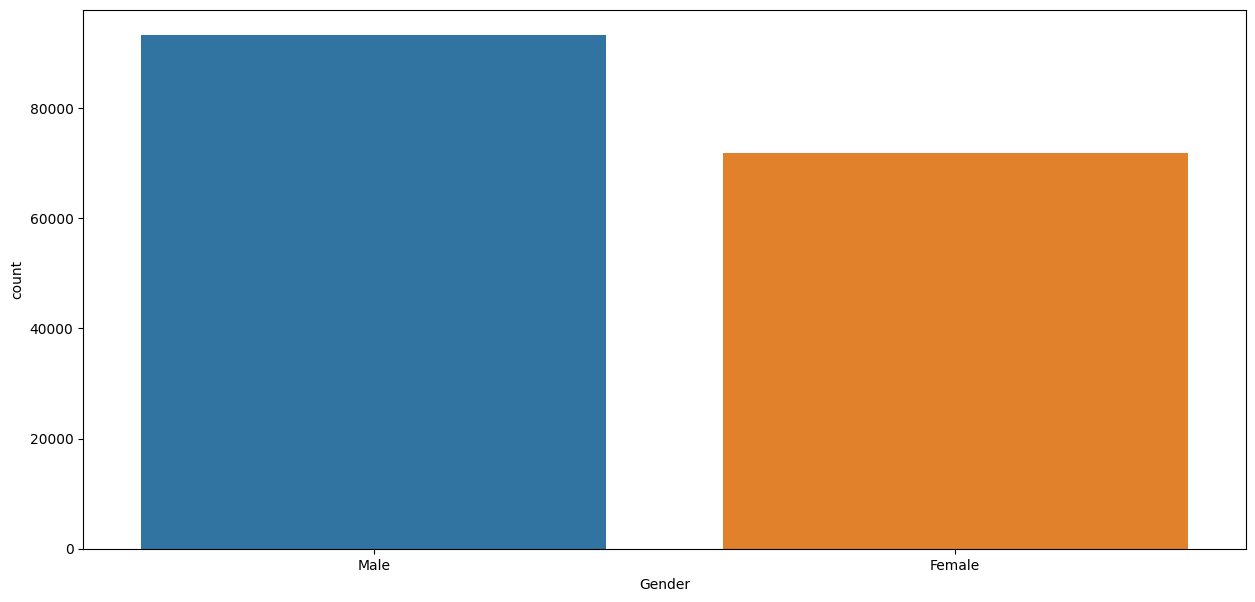

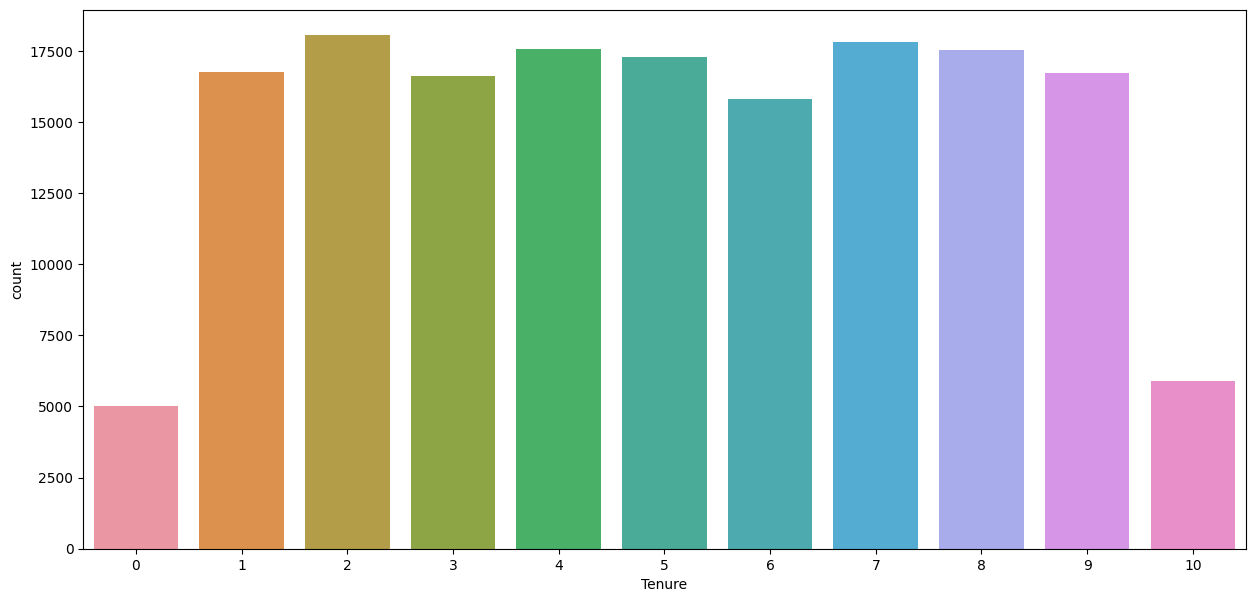

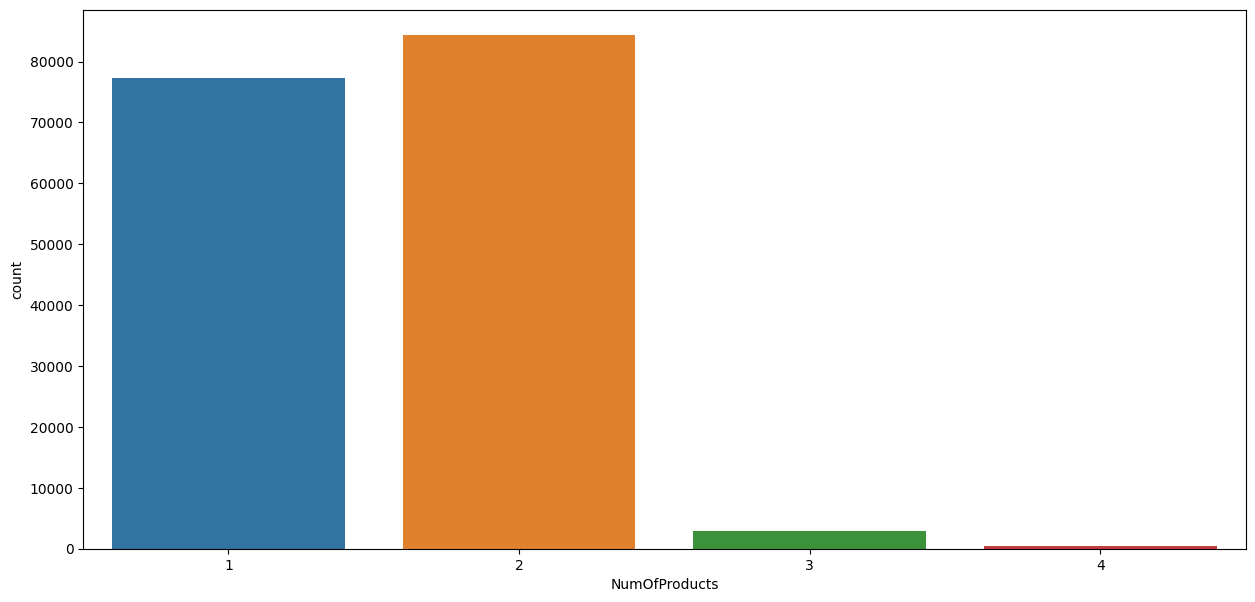

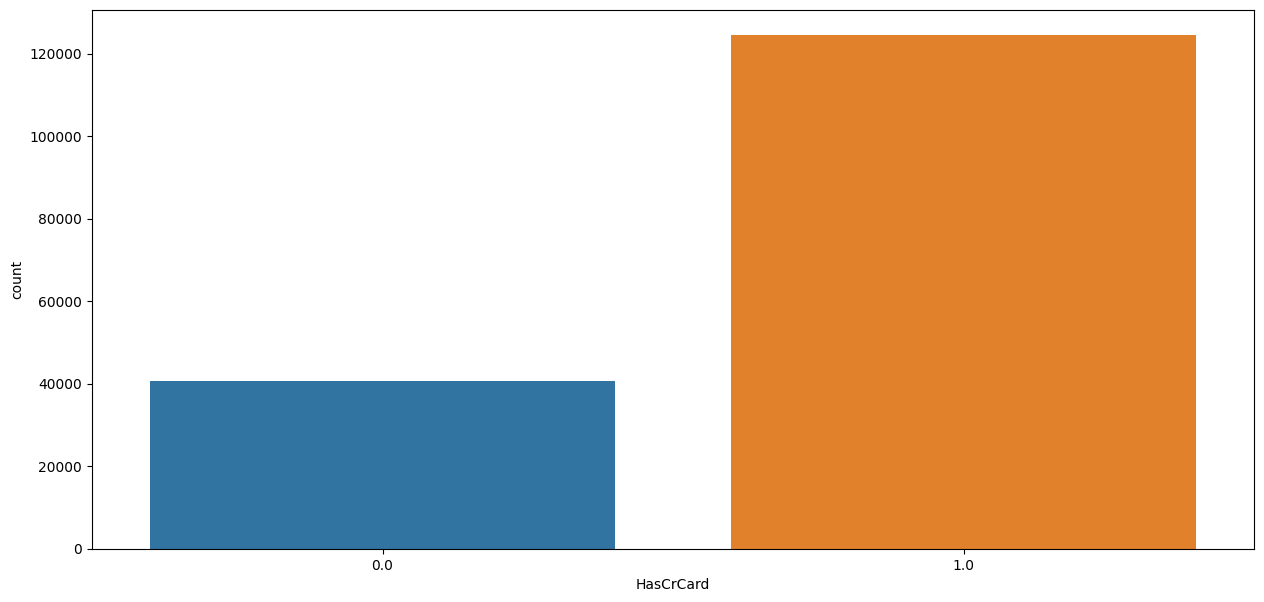

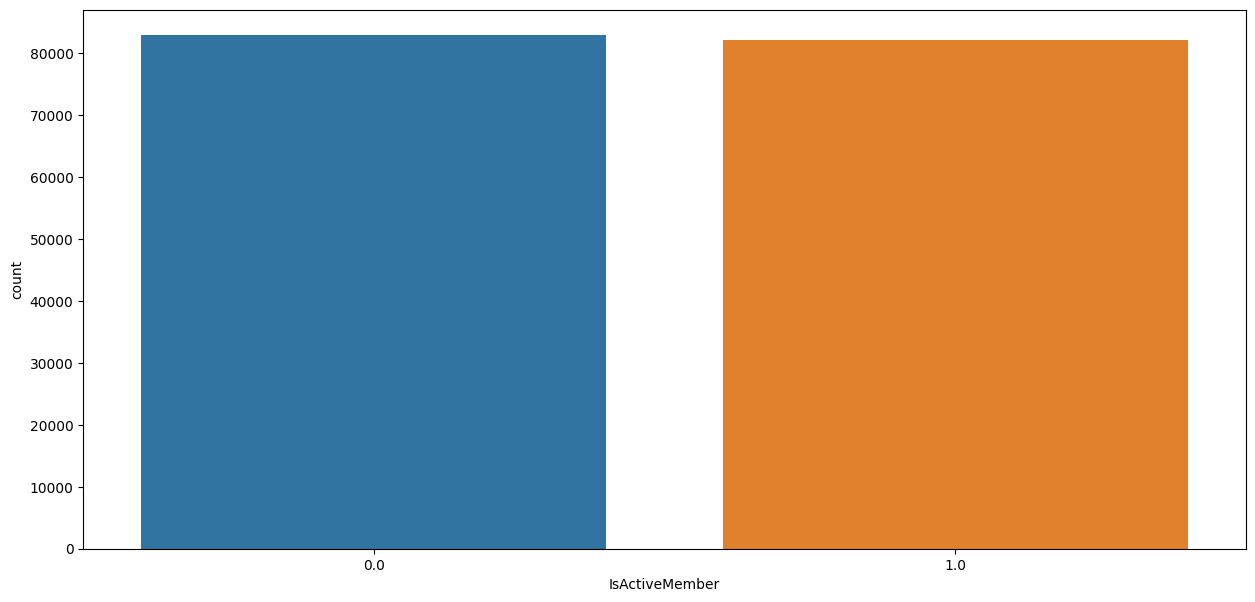

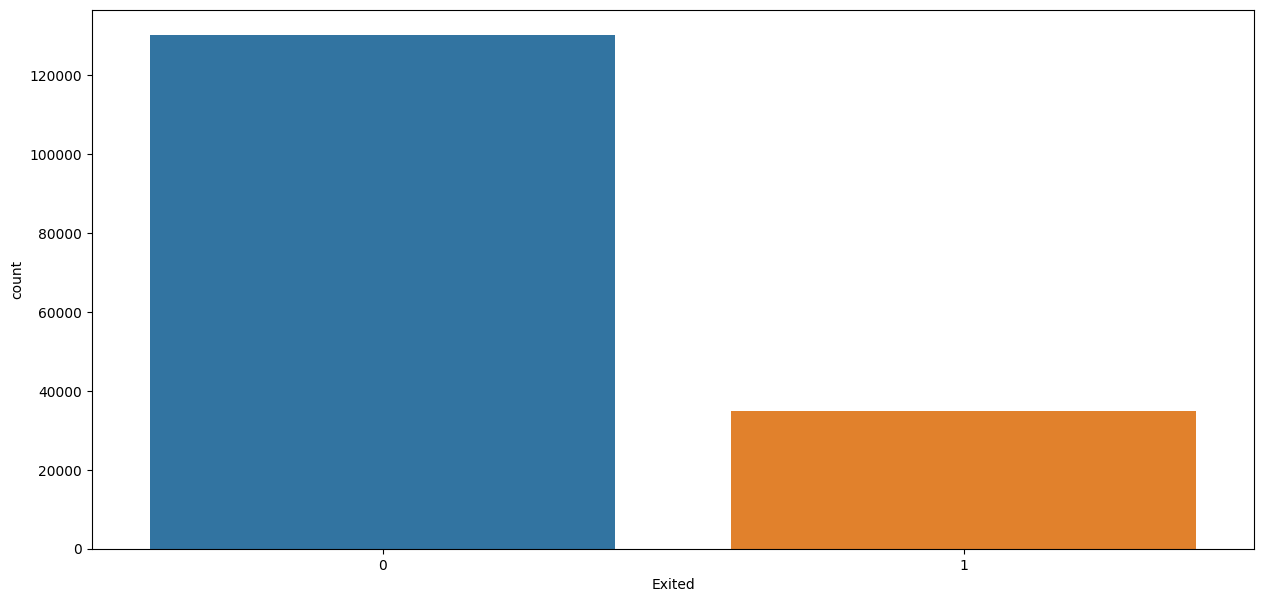

In [28]:
for col in cat_cols:
    plt.figure(figsize=[15,7])
    sns.countplot(df,x=df[col])
    plt.show()

## Histograms of numerical columns

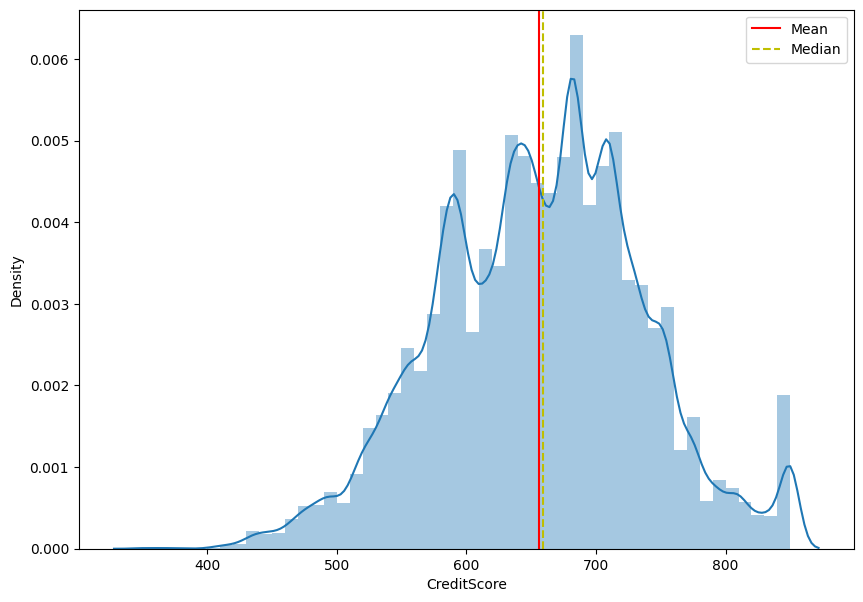

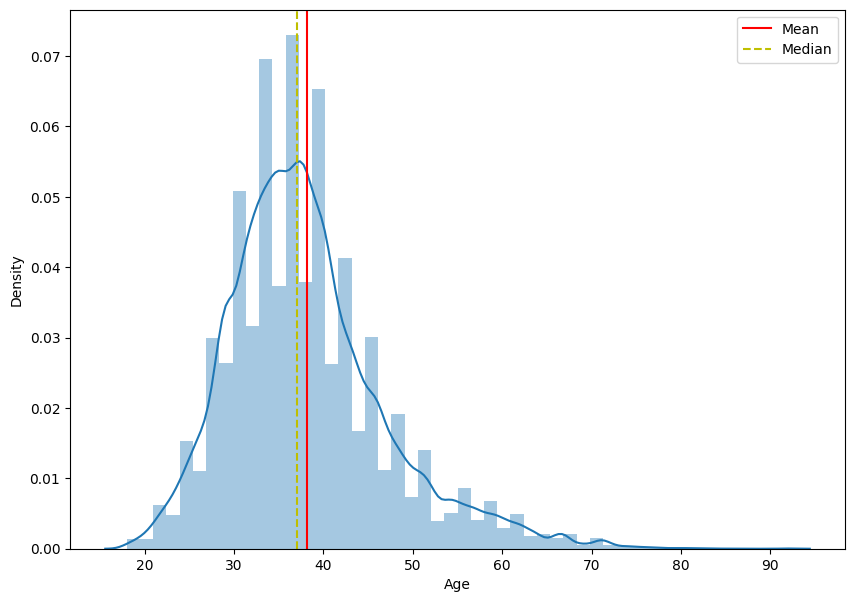

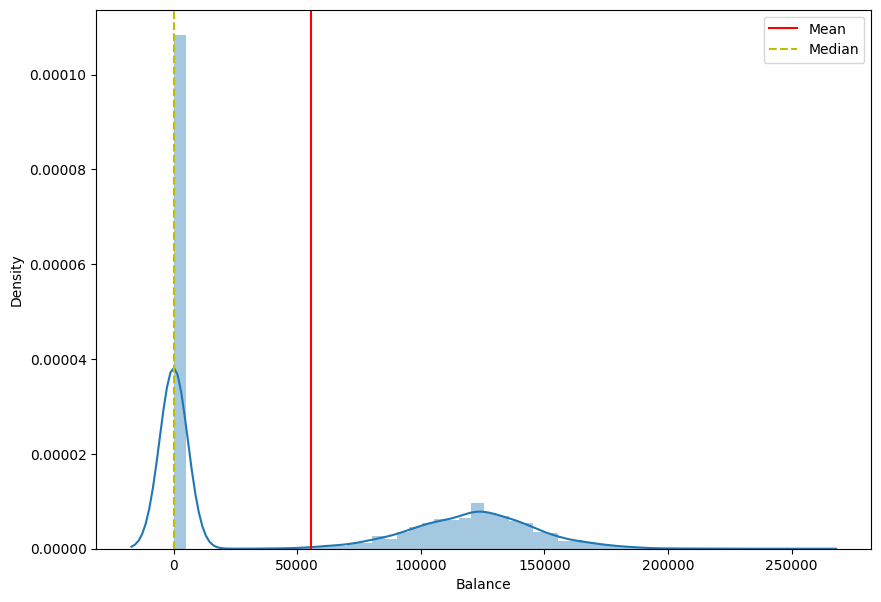

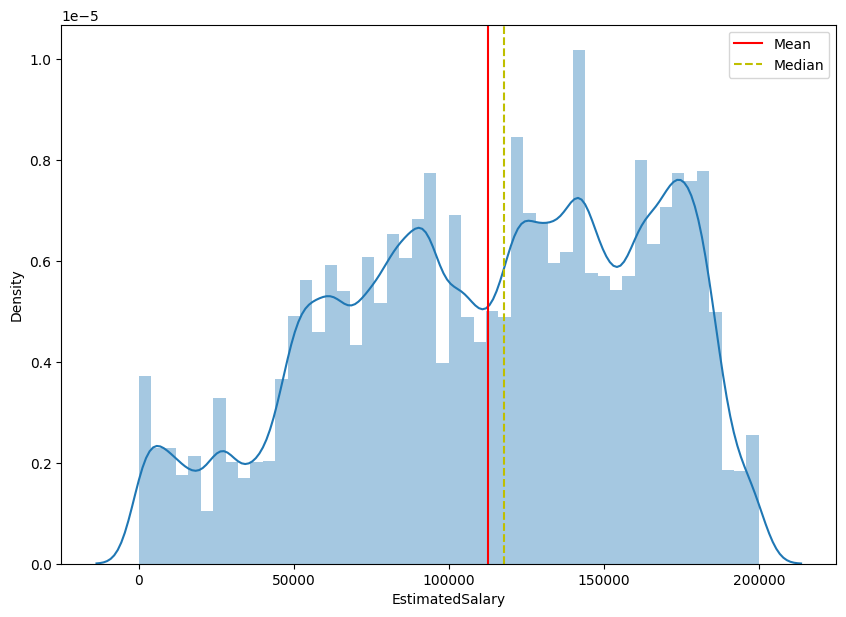

In [29]:
for col in num_cols:
    plt.figure(figsize=[10,7])
    sns.distplot(df[col],kde=True)
    plt.axvline(df[col].mean(),color='r', label='Mean')
    plt.axvline(df[col].median(),color='y', linestyle='--',label='Median')
    plt.legend()
    plt.show()

## Analyzing the Data Hierarchy

In [30]:
import plotly.express as px
fig = px.sunburst(
    df,
    path=['Geography','Gender','NumOfProducts','IsActiveMember','Exited'], 
    color='Exited',color_discrete_map={'1':'gold', '0':'darkblue'},
    width=1200, height=1200
)
fig.show()

## Relationships between different columns

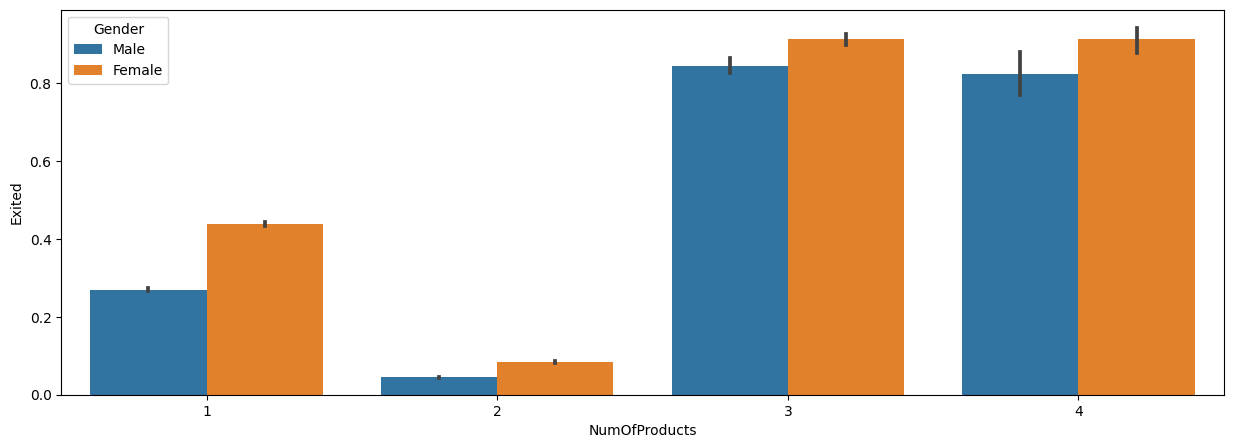

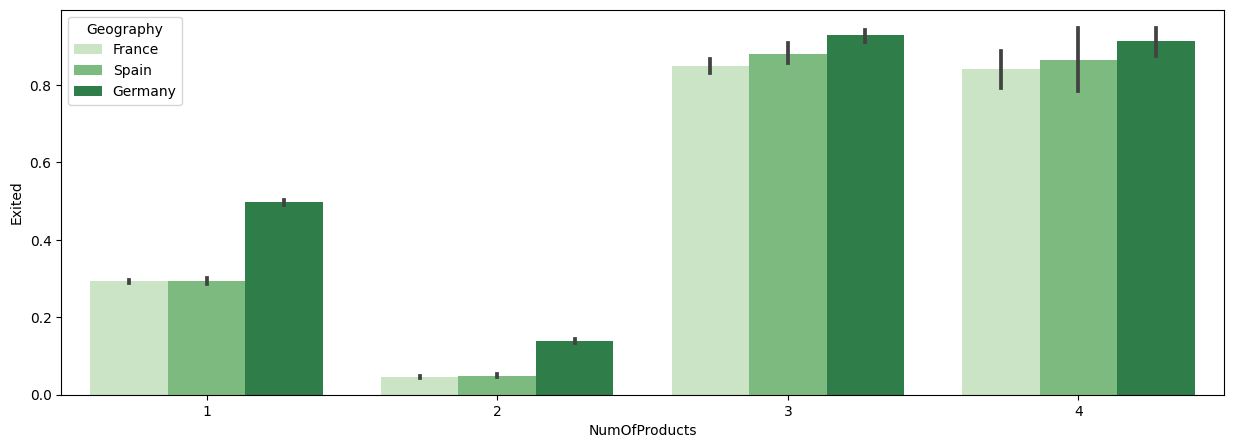

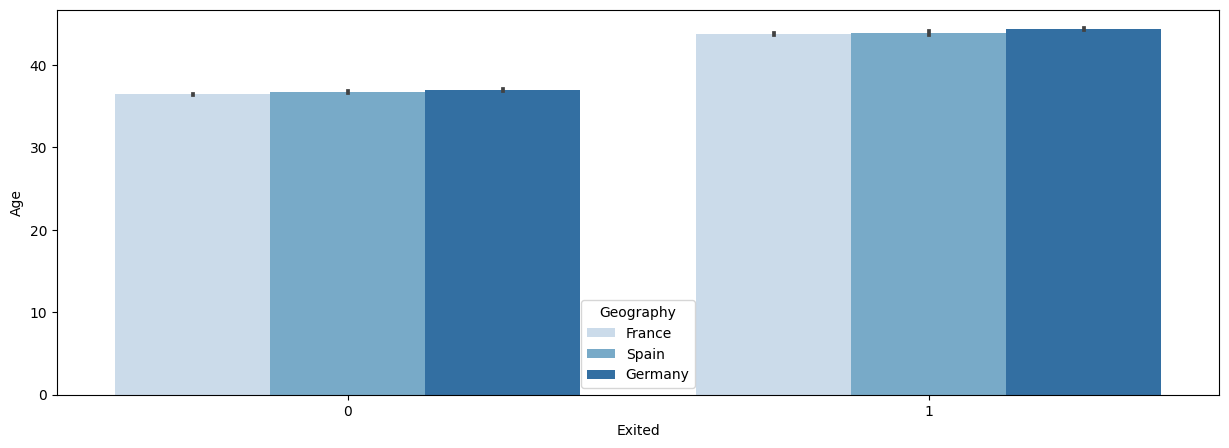

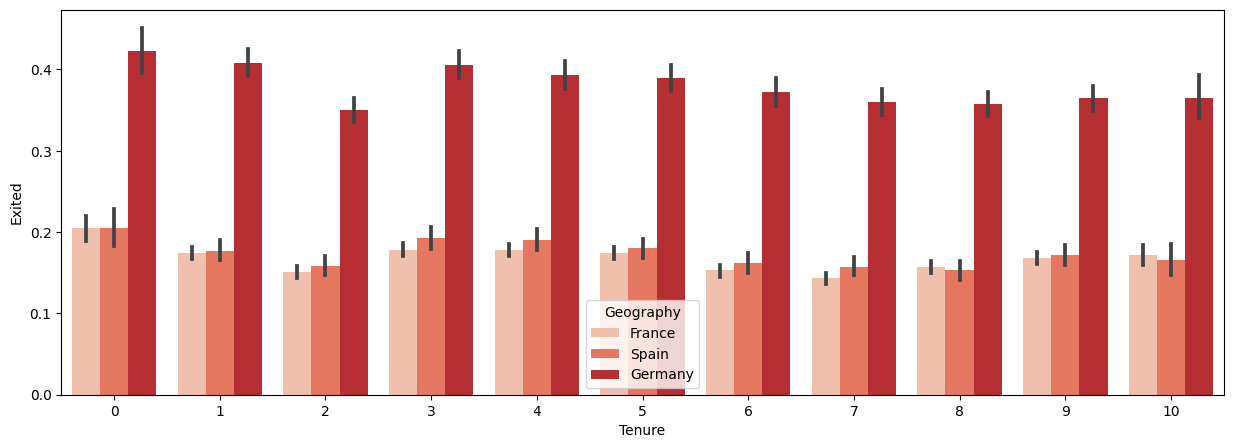

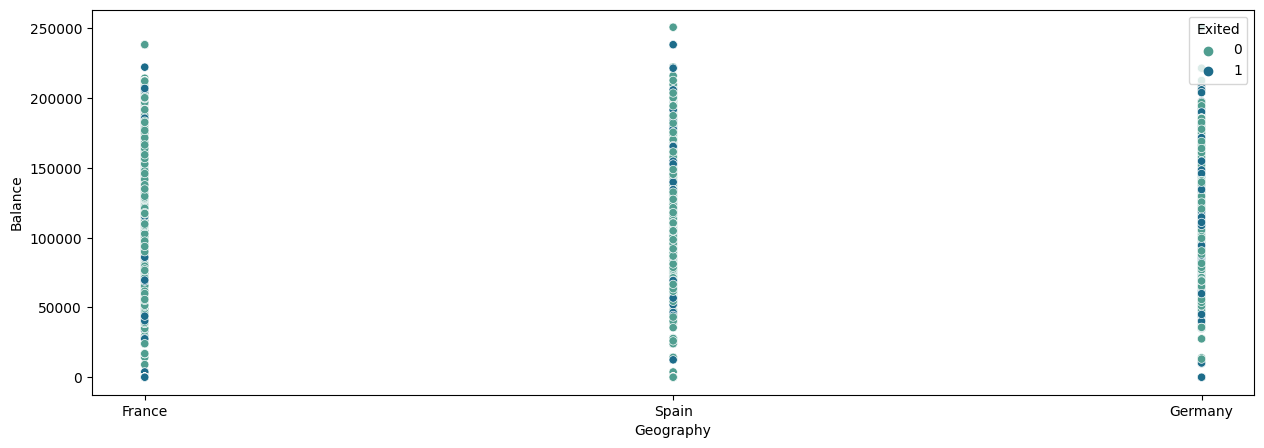

In [31]:
plt.figure(figsize=(15, 5))
s=sns.barplot(train_df,x='NumOfProducts',y='Exited',hue='Gender')
plt.figure(figsize=(15, 5))
s=sns.barplot(train_df,x='NumOfProducts',y='Exited',hue='Geography', palette='Greens')
plt.figure(figsize=(15, 5))
s=sns.barplot(train_df,y='Age',x='Exited',hue='Geography',palette='Blues')
plt.figure(figsize=(15, 5))
s=sns.barplot(train_df,x='Tenure',y='Exited',hue='Geography',palette='Reds')
plt.figure(figsize=(15, 5))
s=sns.scatterplot(train_df,y='Balance',x='Geography',hue='Exited',palette='crest')

# Pre Processing and Features Generation

In [32]:
def colchange(train_df):
    train_df['Geography']=pd.to_numeric(train_df['Geography'].replace(['France','Spain', 'Germany'],[1,2,3]))
    train_df['Gender']=pd.to_numeric(train_df['Gender'].replace(['Male','Female'],[1,0]))
    return(train_df)
train_df=colchange(train_df)
test_df=colchange(test_df)
train_df['Exited']=pd.Categorical(train_df['Exited'])
print(test_df.info())
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      110023 non-null  int64  
 1   Geography        110023 non-null  int64  
 2   Gender           110023 non-null  int64  
 3   Age              110023 non-null  float64
 4   Tenure           110023 non-null  int64  
 5   Balance          110023 non-null  float64
 6   NumOfProducts    110023 non-null  int64  
 7   HasCrCard        110023 non-null  float64
 8   IsActiveMember   110023 non-null  float64
 9   EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 8.4 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   CreditScore      165034 non-null  int64   
 1   Geography 

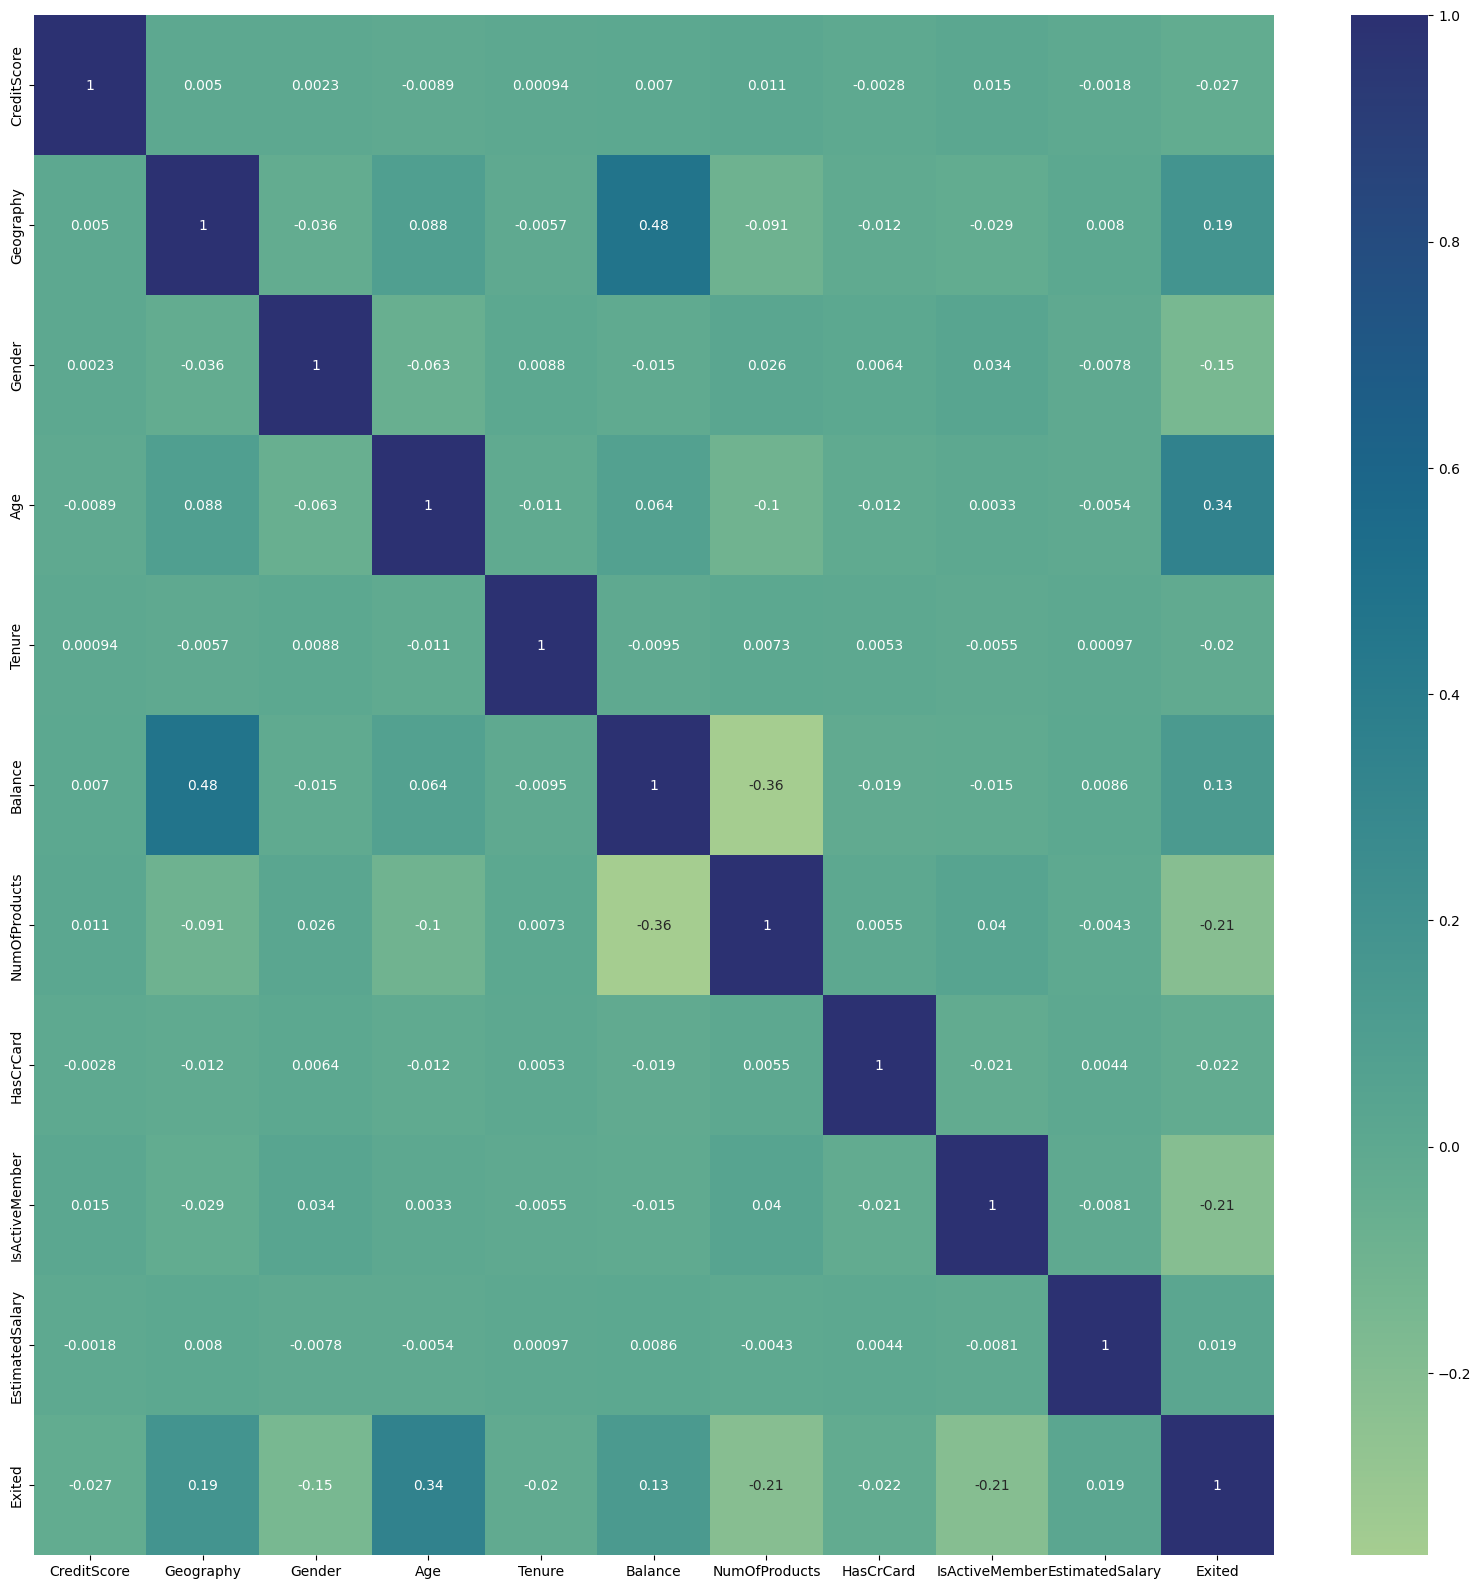

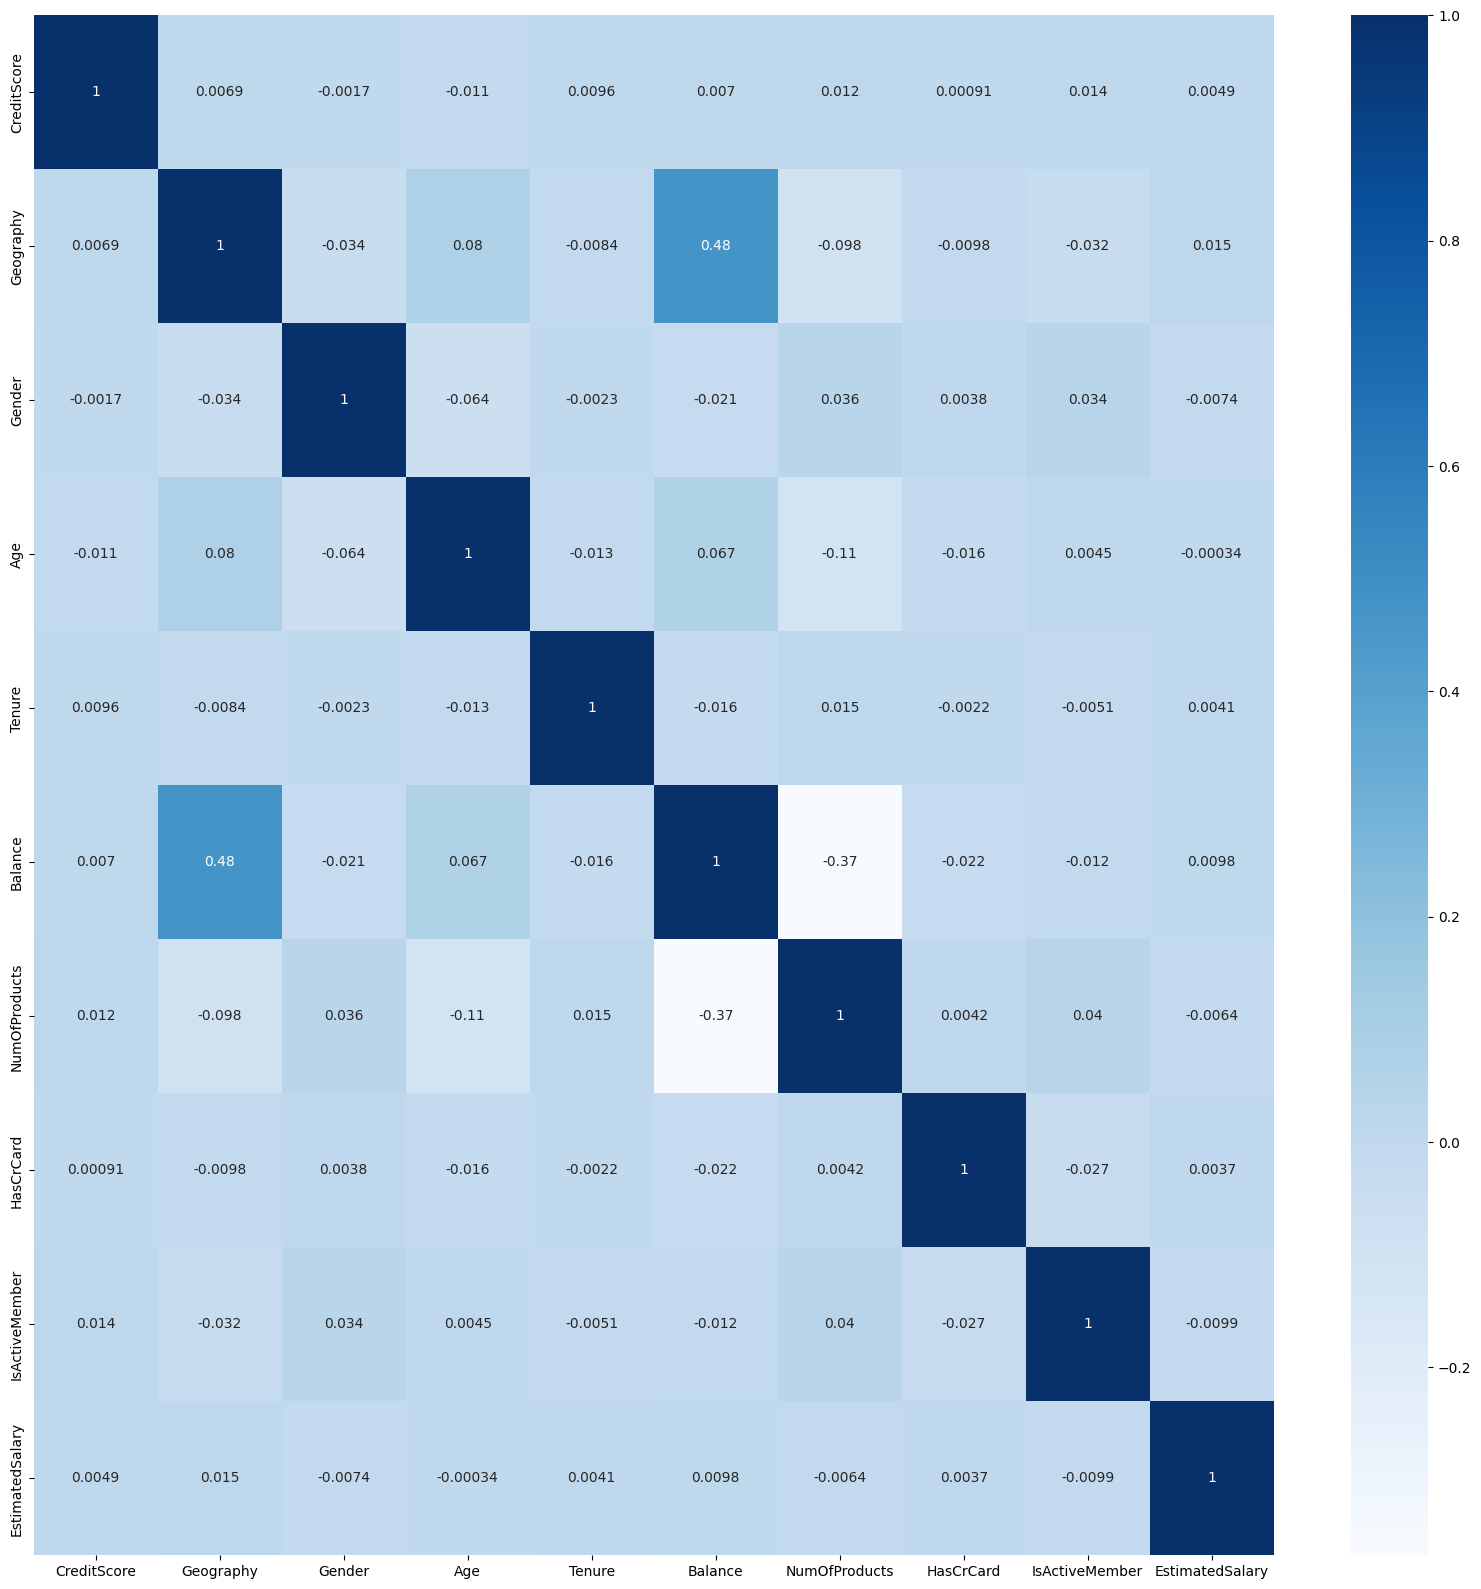

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = train_df.corr()
# plot the heatmap
plt.figure(figsize=(20, 20))
s=sns.heatmap(corr,annot=True, cmap='crest')
corr = test_df.corr()
# plot the heatmap
plt.figure(figsize=(20, 20))
s=sns.heatmap(corr,annot=True, cmap='Blues')

In [34]:
train_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,1,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,1,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,1,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,1,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,792,1,1,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,565,1,1,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,554,2,0,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Test and Train Split

In [35]:
X=train_df.drop(columns=['Exited'])
y=(train_df[['Exited']].astype('int64'))

print(X.describe())
print(y.info())

         CreditScore      Geography         Gender            Age  \
count  165034.000000  165034.000000  165034.000000  165034.000000   
mean      656.454373       1.638808       0.564429      38.125888   
std        80.103340       0.806298       0.495833       8.867205   
min       350.000000       1.000000       0.000000      18.000000   
25%       597.000000       1.000000       0.000000      32.000000   
50%       659.000000       1.000000       1.000000      37.000000   
75%       710.000000       2.000000       1.000000      42.000000   
max       850.000000       3.000000       1.000000      92.000000   

              Tenure        Balance  NumOfProducts      HasCrCard  \
count  165034.000000  165034.000000  165034.000000  165034.000000   
mean        5.020353   55478.086689       1.554455       0.753954   
std         2.806159   62817.663278       0.547154       0.430707   
min         0.000000       0.000000       1.000000       0.000000   
25%         3.000000       0.0000

## Scaling the Input

In [36]:
def scale(X):
    from sklearn import preprocessing
    scaled=preprocessing.StandardScaler()
    scaler=scaled.fit(X)
    X=scaler.transform(X)
    return X

In [37]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(scale(X),y,train_size=0.8, random_state=42)
X.keys()
test_df=scale(test_df)

In [38]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Exited  165034 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


# Training The Models

In [39]:
def evaluate(y_test,ypred):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("Accuracy: ",accuracy_score(y_test,y_pred)) 
    print("Precision Score : ", precision_score(y_test,y_pred)) #precision measures the proportion of true positive predictions among all positive instances. how many of survived predicted actually survived, doesn't verifies 0's 70 survived as preicted whereas actually 92 survived so 70/92 will be the precision.  if we predicted 70 survived, so presion will tell how many of those 70 predicted survived matches the actual row by row data. It checkes all positives and verifies if the answer is true for each row?
    print("Recall Score: ", recall_score(y_test,y_pred, average='macro')) #Recall measures the proportion of true positive predictions among all actual positive instalnces. If we predicted 100 survived correctly whereas actually 100 survived out of which 67 predicted correctly so recall will be 0.67
    print("F1 Score: ",f1_score(y_test,y_pred)) #mean of recall and precision
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    s=sns.heatmap(cm,annot=True, cmap='Reds')


# HyperParameter Tuning

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
result=pd.DataFrame(columns=['id', 'RF','MLP','XGB','ABC','GBC','Exited'])
result.id=test[['id']]
w=pd.DataFrame(columns=['mod','weight'])
models = {
   'RF': RandomForestClassifier(),
   'XGB' : xgb.XGBClassifier(objective="binary:logistic",seed=42),
   'ABC': AdaBoostClassifier(),
   'GBC': GradientBoostingClassifier(validation_fraction=0.1, n_iter_no_change=15),
   'MLP':MLPClassifier() 
}
grid_param={
   'MLP': {
       'solver': ['lbfgs'], 
       'early_stopping':[1],
       'activation': ['tanh'], 
       'max_iter': [500], 
       'alpha': [10.0 ** -7], 
       'hidden_layer_sizes':[12], 
       'learning_rate': ['adaptive'],
       'verbose':[0] 
          },
   'RF' : {
       'bootstrap': [True], 
       'ccp_alpha': 10.0 ** -np.arange(4,8,1), 
       'max_depth': [None], 
       'max_leaf_nodes': [None], 
       'max_samples': [None], 
       'min_impurity_decrease': [0.0], 
       'min_samples_leaf': [5], 
       'min_samples_split': [3], 
       'n_estimators': [70], 
       'warm_start': [False] 
        },
#'bootstrap': True, 'ccp_alpha': 0, 'max_depth': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 105, 'warm_start': True
'XGB': {
        'n_estimators':[5000],
        'learning_rate': [0.001],
        'max_depth': np.arange(1,10,1),
        'subsample': np.arange(0.5, 1,0.1),
        'colsample_bytree':[0.05,0.1,0.5,1],
        'min_child_weight':[1, 5, 15, 20],
        'alpha': 10.0 ** -np.arange(7,10,1)
          },
   'GBC': {
        'loss':['exponential'],
        'criterion': ['friedman_mse'],
        'n_estimators': [1000],
        'learning_rate': [0.2],
        'min_impurity_decrease':[0.1],
        'ccp_alpha': 10.0 ** -np.arange(4,8,1),
        'subsample': [1]
        },
  'ABC':  {
        'n_estimators':[1000],
        'learning_rate':[0.1]
        },
    #Model:  GBC  Accuracy: 0.79  Best Parameters: {'ccp_alpha': 0.03, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'min_impurity_decrease': 0.1, 'n_estimators': 1000, 'subsample': 1}
}
for name,mod in tqdm(models.items()):
   gs = GridSearchCV(estimator=mod, param_grid=grid_param[name], verbose=3,cv=3, scoring='accuracy')
   gs.fit(X_train,np.ravel(y_train))
   print('Model: ', name, ' Accuracy:',format(gs.best_score_,".2f"),  ' Best Parameters:',gs.best_params_)
   y_pred=gs.predict(X_test)
   w.loc[len(w)]=[name,gs.best_score_]
   result[name]=gs.predict_proba(scale(test_df))[:,1]
   
   evaluate(y_test,y_pred)
# Model:  DT  Accuracy: 0.80  Best Parameters: {'ccp_alpha': 0.0, 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}
#Model:  RF  Accuracy: 0.86  Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 110, 'warm_start': True}
#Model:  MLP  Accuracy: 0.86  Best Parameters: {'activation': 'relu', 'alpha': 1e-08, 'early_stopping': 1, 'hidden_layer_sizes': 13, 'learning_rate': 'adaptive', 'max_iter': 200, 'random_state': 9, 'solver': 'lbfgs', 'verbose': 0}

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END bootstrap=True, ccp_alpha=0.0001, max_depth=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=3, n_estimators=70, warm_start=False;, score=0.863 total time=  12.8s
[CV 2/3] END bootstrap=True, ccp_alpha=0.0001, max_depth=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=3, n_estimators=70, warm_start=False;, score=0.864 total time=  12.6s
[CV 3/3] END bootstrap=True, ccp_alpha=0.0001, max_depth=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=3, n_estimators=70, warm_start=False;, score=0.864 total time=  12.9s
[CV 1/3] END bootstrap=True, ccp_alpha=1e-05, max_depth=None, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=5, min_samples_split=3, n_estimators=70, warm_start=False;, score=0.862 total time= 

# Aggregating the Best Results from different Algorithms

In [ ]:
w


In [ ]:
rf=w['weight'][w['mod']=='RF'].item()
xgb=w['weight'][w['mod']=='XGB'].item()
abc=w['weight'][w['mod']=='ABC'].item()
gbc=w['weight'][w['mod']=='GBC'].item()
mlp=w['weight'][w['mod']=='MLP'].item()
wmx=w['weight'].max()

In [ ]:
result

# Creating the Submission File

In [ ]:
result['Exited']= np.round_(((result.RF*rf)+(result.MLP*mlp)+(result.XGB*xgb)+(result.ABC*abc)+(result.GBC*gbc))/(5*wmx),decimals=1)

result

submission=result[['id','Exited']]
submission.to_csv('submission.csv', index=False)

In [ ]:
submission